In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

In [ ]:
import subprocess
import sys
def install(package):
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', package], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
install('ipympl')

from google.colab import output
output.enable_custom_widget_manager()


In [ ]:
%matplotlib ipympl

#Homography

In [ ]:
def data_normalization(points):

    mean = np.mean(points, axis=0)
    std_dev = np.std(points, axis=0)


    T = np.array([[1/std_dev[0], 0, -mean[0]/std_dev[0]],
                  [0, 1/std_dev[1], -mean[1]/std_dev[1]],
                  [0, 0, 1]])


    normalized_points = (T @ np.vstack((points.T, np.ones((1, points.shape[0]))))).T[:, :2]

    return normalized_points, T


def find_homography(points_source, points_target):

    points_source, T = data_normalization(np.array(points_source))
    points_target, Tp = data_normalization(np.array(points_target))


    A = []
    for i in range(points_source.shape[0]):  # Loop over all points
        x, y = points_source[i]
        x_t, y_t = points_target[i]
        A_for_one_point = [
            [-x, -y, -1, 0, 0, 0, x_t * x, x_t * y, x_t],
            [0, 0, 0, -x, -y, -1, y_t * x, y_t * y, y_t],
        ]
        A.extend(A_for_one_point)

    A = np.array(A)
    Htemp = np.zeros((3, 3))

    U, D, Vt = np.linalg.svd(A)

    Htemp[0, :] = Vt[-1][0:3]
    Htemp[1, :] = Vt[-1][3:6]
    Htemp[2, :] = Vt[-1][6:9]


    H = np.linalg.inv(Tp) @ Htemp @ T

    return H / H[-1, -1]





#Warping

In [ ]:
def bilinear_interpolation(source_image, x, y):
    x0, y0 = int(x), int(y)
    x1, y1 = min(x0 + 1, source_image.shape[1] - 1), min(y0 + 1, source_image.shape[0] - 1)

    Ia = source_image[y0, x0]
    Ib = source_image[y0, x1]
    Ic = source_image[y1, x0]
    Id = source_image[y1, x1]

    wa = (x1 - x) * (y1 - y)
    wb = (x - x0) * (y1 - y)
    wc = (x1 - x) * (y - y0)
    wd = (x - x0) * (y - y0)

    return wa * Ia + wb * Ib + wc * Ic + wd * Id


In [ ]:
def warp_perspective_manual(source_image, H, output_shape):
    width, height = output_shape
    warped_image = np.zeros((height, width, source_image.shape[2]), dtype=source_image.dtype)
    H_inv = np.linalg.inv(H)

    for y in range(height):
        for x in range(width):

            src_coords = H_inv @ np.array([x, y, 1])
            src_x, src_y = src_coords[0] / src_coords[2], src_coords[1] / src_coords[2]


            if 0 <= src_x < source_image.shape[1] and 0 <= src_y < source_image.shape[0]:

                warped_image[y, x] = bilinear_interpolation(source_image, src_x, src_y)

    return warped_image


In [ ]:
def warpPerspective(source_image, H, output_shape):
    w, h = output_shape[:2]

    y, x = np.indices((h, w))
    dst_hom_pts = np.stack((x.ravel(), y.ravel(), np.ones(y.size)))


    src_hom_pts = np.dot(np.linalg.inv(H), dst_hom_pts)
    src_hom_pts /= src_hom_pts[2]


    src_hom_pts = np.round(src_hom_pts).astype(int)
    src_x = np.clip(src_hom_pts[0], 0, source_image.shape[1] - 1)
    src_y = np.clip(src_hom_pts[1], 0, source_image.shape[0] - 1)


    warped_image = np.zeros((h, w, source_image.shape[2]), dtype=source_image.dtype)


    for ch in range(source_image.shape[2]):
        warped_image[y.ravel(), x.ravel(), ch] = source_image[src_y, src_x, ch]

    return warped_image

#Test on image

In [ ]:
image_path = "/content/palawan.jpg"
#image_path="/content/oblique_book.png"
#image_path="/content/spider_processed_image.jpg"
#image_path="/content/thomso_left_view.jpg"
#image_path="/content/175_tilted.jpg"
#image_path="/content/iit_tilted.jpg"
#image_path="/content/roorkee_tilted.jpg"
#image_path = "/content/fake_superman.jpg"
#image_path = "/content/love_desert.jpg"
#image_path = "/content/tilted_woman.jpg"

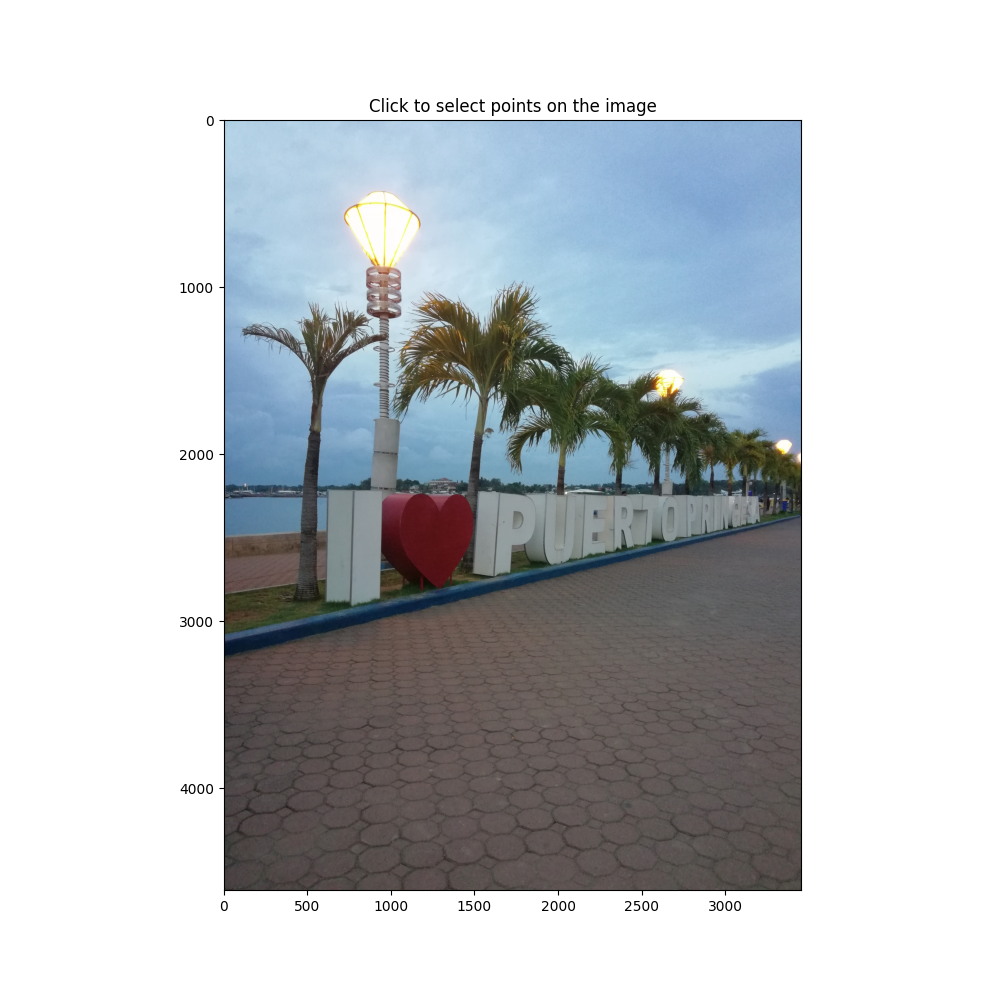


Selected Points: []
Point selected: (557.55, 2175.43)
Point selected: (563.53, 3004.87)
Point selected: (3208.64, 2406.43)
Point selected: (3190.69, 2214.93)


In [ ]:
import matplotlib.pyplot as plt
import cv2


points = []


img = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img_rgb)
ax.set_title("Click to select points on the image")


def onclick(event):
    if event.xdata is not None and event.ydata is not None:
        ix, iy = event.xdata, event.ydata
        points.append((ix, iy))
        print(f"Point selected: ({ix:.2f}, {iy:.2f})")


        ax.plot(ix, iy, 'ro')
        fig.canvas.draw()


cid = fig.canvas.mpl_connect('button_press_event', onclick)

plt.show()

print("\nSelected Points:", points)

In [ ]:
source_points=points

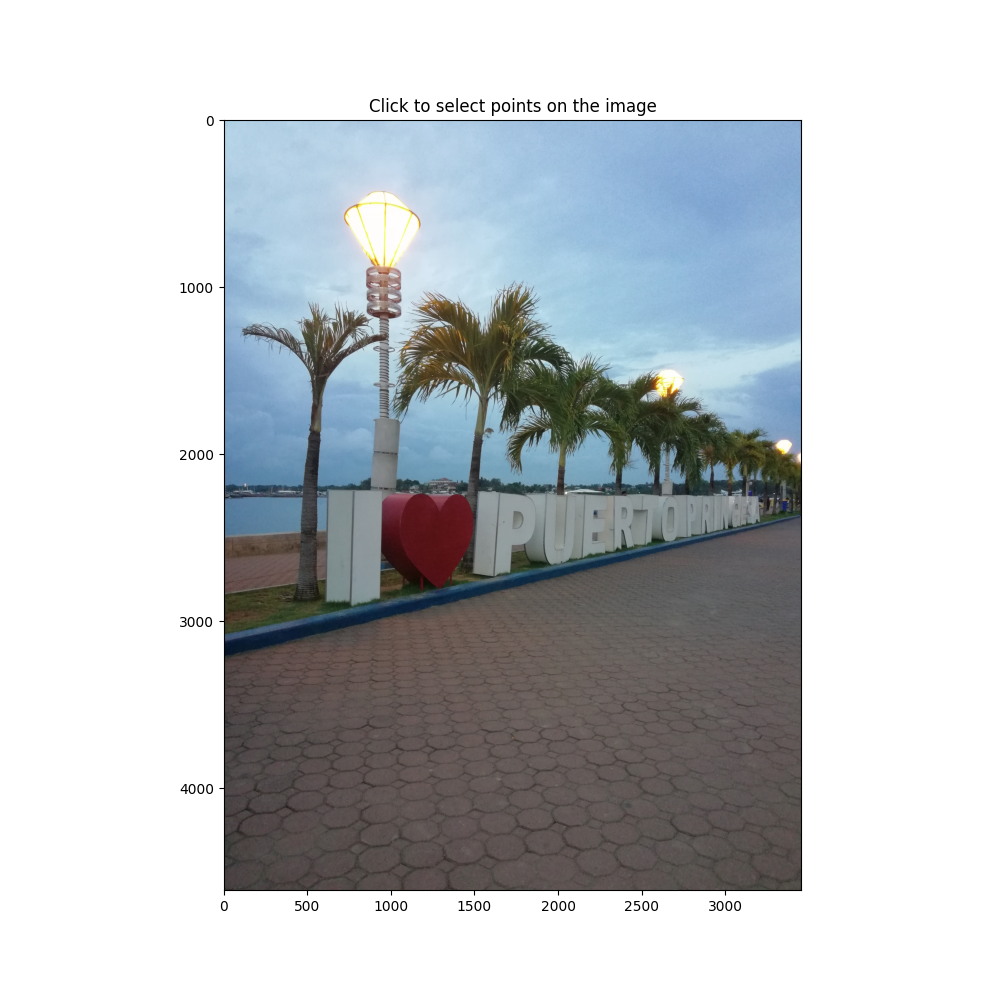


Selected Points: []
Point selected: (42.89, 2055.75)
Point selected: (24.93, 3215.52)
Point selected: (3388.18, 3294.52)
Point selected: (3370.22, 2106.01)


In [ ]:
import matplotlib.pyplot as plt
import cv2


points = []


img = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img_rgb)
ax.set_title("Click to select points on the image")


def onclick(event):
    if event.xdata is not None and event.ydata is not None:  # Check if click is within the image
        ix, iy = event.xdata, event.ydata
        points.append((ix, iy))
        print(f"Point selected: ({ix:.2f}, {iy:.2f})")


        ax.plot(ix, iy, 'ro')  # Red dot
        fig.canvas.draw()


cid = fig.canvas.mpl_connect('button_press_event', onclick)

plt.show()

print("\nSelected Points:", points)

In [ ]:
destination_points=points

In [ ]:

points_source = np.array([[x, y, 1] for x, y in source_points])
points_target = np.array([[x, y, 1] for x, y in destination_points])

In [ ]:
print(points_source)
print(points_target)

[[5.57546753e+02 2.17543350e+03 1.00000000e+00]
 [5.63531169e+02 3.00487351e+03 1.00000000e+00]
 [3.20864286e+03 2.40643195e+03 1.00000000e+00]
 [3.19068961e+03 2.21493065e+03 1.00000000e+00]]
[[4.28870130e+01 2.05574519e+03 1.00000000e+00]
 [2.49337662e+01 3.21552494e+03 1.00000000e+00]
 [3.38817532e+03 3.29451921e+03 1.00000000e+00]
 [3.37022208e+03 2.10601429e+03 1.00000000e+00]]


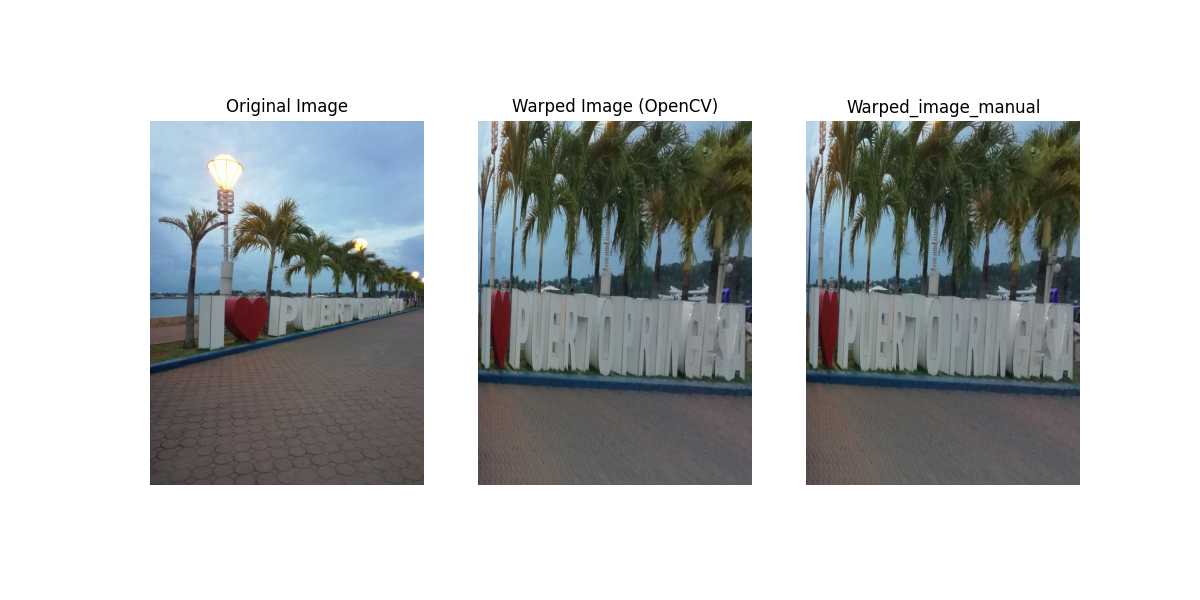

Computed Homography Matrix:
[[ 2.49463741e-01 -2.07603886e-02 -5.54781029e+01]
 [-5.54792199e-01  1.31470067e+00 -7.07815493e+02]
 [-2.62490049e-04  1.96818401e-05  1.00000000e+00]]


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


H = find_homography(source_points, destination_points)

img = cv2.imread(image_path)


warped_image = cv2.warpPerspective(img, H, (img.shape[1], img.shape[0]))
#warped_image_man = warp_perspective_manual(img, H, (img.shape[1], img.shape[0]))
warped_image_man = warpPerspective(img, H, (img.shape[1], img.shape[0]))


plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Warped Image (OpenCV)")
plt.imshow(cv2.cvtColor(warped_image, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Warped_image_manual")
plt.imshow(cv2.cvtColor(warped_image_man, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.show()



# Print the computed homography matrix
print("Computed Homography Matrix:")
print(H)
#print(H_earlier)


In [ ]:
cv2.imwrite('palawan_after homography.jpg', warped_image_man)

True